In [1]:
# Add root path to sys to allow importing src code

import sys
sys.path.append("../")

import sunpy.map as smap
import sqlite3
import pandas as pd
import numpy as np
from src.cmesrc.config import SDOML_TIMESTAMP_INFO, CMESRC_DB
from sunpy.data.test import get_dummy_map_from_header
from astropy.io import fits
import pickle
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

/home/julio/cmesrc/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open(SDOML_TIMESTAMP_INFO, "rb") as f:
    sdoml_timestamp_info = pickle.load(f)

In [6]:
con = sqlite3.connect(CMESRC_DB)
con.execute("PRAGMA foreign_keys = ON")
cur = con.cursor()

Let's test the conversion from stonyhurst into pixels

In [28]:
map_data = np.zeros((512, 512))

In [111]:
sample_key = list(sdoml_timestamp_info.keys())[70000]
sample_key

'2012-02-09 08:24:00'

In [112]:
sample_header = sdoml_timestamp_info[sample_key]["header"]
sample_fits_header = fits.Header()

for keyword, value in sample_header.items():
    sample_fits_header[keyword] = value


In [113]:
sample_map = smap.Map(map_data, sample_fits_header)

(<matplotlib.patches.Circle at 0x7f0f056beb80>, None)

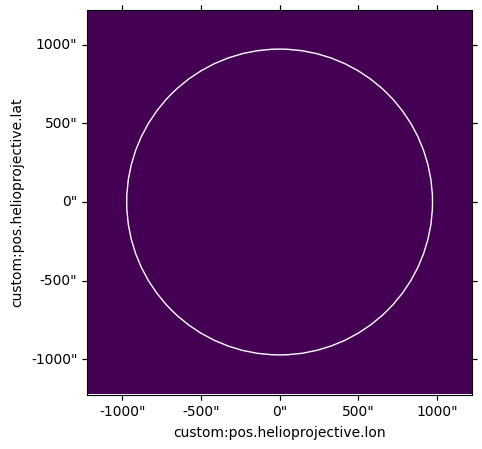

In [114]:
# Plot a sunpy map and get the figure and axes

# Sun size

sun_radius = sample_map.rsun_obs.value

cdelt1, cdelt2 = np.abs(sample_map.scale.axis1.value), np.abs(sample_map.scale.axis2.value)

solar_radii_pixels = sun_radius / ((cdelt1 + cdelt2) / 2)

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(projection=sample_map)

plt.imshow(sample_map.data, origin="lower")
sample_map.draw_limb()

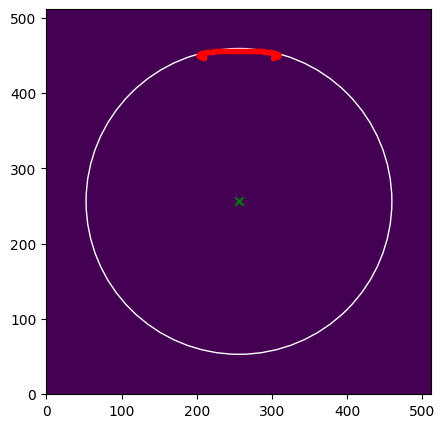

In [153]:
fig, ax = plt.subplots(figsize=(5, 5))

x = np.linspace(-120,120,100)
y = np.full(100,75)

stonyhurst_coords = SkyCoord([[xi, yi] for xi, yi in zip(x, y)], unit="deg", frame="heliographic_stonyhurst", obstime=sample_map.date, observer="sdo")

pixel_coords = sample_map.world_to_pixel(stonyhurst_coords)
ax.imshow(sample_map.data, origin="lower")
limb = plt.Circle((sample_map.data.shape[0]/2, sample_map.data.shape[1]/2), radius=solar_radii_pixels, color="white", fill=False)
ax.add_patch(limb)
ax.scatter(pixel_coords[0], pixel_coords[1], marker=".", color="red")
ax.scatter(sample_map.data.shape[0]/2, sample_map.data.shape[1]/2 , marker="x", color="green")

In [155]:
indices = np.linspace(0, len(sdoml_timestamp_info) - 1, 365)
indices = [int(i) for i in indices]

keys = list(sdoml_timestamp_info.keys())

sample_keys = [keys[i] for i in indices]
del keys

In [159]:
data = np.zeros((512, 512))

stonyhurst_centre = SkyCoord(0, 0, unit="deg", frame="heliographic_stonyhurst")

x = []
y = []

for key in sample_keys:
    header = sdoml_timestamp_info[key]["header"]

    sunpy_map = smap.Map(data, header)

    stonyhurst_pix = sunpy_map.world_to_pixel(stonyhurst_centre)

    x.append(stonyhurst_pix[0].value)
    y.append(stonyhurst_pix[1].value)

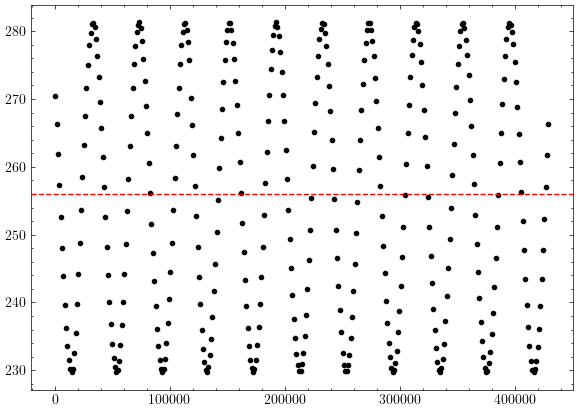

In [166]:
plt.style.use("science")

fig, ax = plt.subplots(figsize=(7, 5))

ax.axhline(y=256, color="r", linestyle="--")

ax.scatter(indices, y, marker=".", color="k")

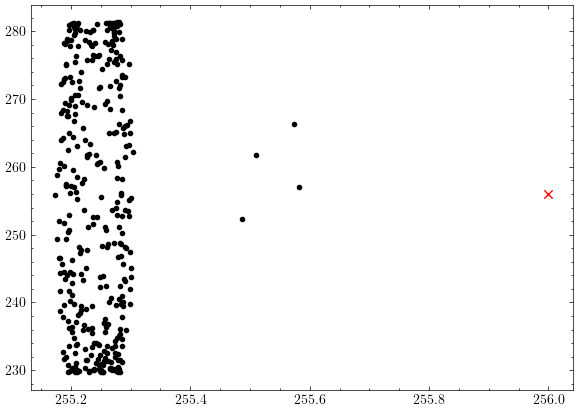

In [167]:
plt.style.use("science")

fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(x, y, marker=".", color="k")

ax.scatter(256, 256, marker="x", color="r")

In [169]:
cur.close()
con.close()

### I honestly don't know why these images are tilted
Downloaded directly from JSOC has the same issue

## Anyways, ignoring that for now

In [3]:
from astropy.coordinates import SkyCoord
from sunpy.coordinates import HeliographicStonyhurst
import astropy.units as u
from tqdm import tqdm

In [4]:
con = sqlite3.connect(CMESRC_DB)
con.execute("PRAGMA foreign_keys = ON")
cur = con.cursor()
write_cursor = con.cursor()
im_cursor = con.cursor()

In [5]:
# Print all table names

cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('harps',), ('harps_bbox',), ('cmes',), ('flares',), ('dimmings',), ('images',), ('pixel_values',), ('pixels',), ('x_pixel_values',), ('y_pixel_values',), ('harps_pixel_bbox',)]


In [6]:
# Print all column names of the harps_pixel table

cur.execute("PRAGMA table_info(harps_pixel_bbox)")
print(cur.fetchall())

[(0, 'harpnum', 'INTEGER', 0, None, 1), (1, 'timestamp', 'TEXT', 0, None, 2), (2, 'x_min', 'INTEGER', 1, None, 0), (3, 'x_max', 'INTEGER', 1, None, 0), (4, 'y_min', 'INTEGER', 1, None, 0), (5, 'y_max', 'INTEGER', 1, None, 0), (6, 'x_cen', 'INTEGER', 1, None, 0), (7, 'y_cen', 'INTEGER', 1, None, 0)]


In [7]:
cur.execute("SELECT * FROM harps_pixel_bbox LIMIT 5;")
print(cur.fetchall())

[]


In [15]:
DELETE = True
if DELETE:
    yes = input("Delete for sure?")
    if yes in ["yes", "y", "Y"]:
#        cur.execute("PRAGMA foreign_keys = OFF;")
        cur.execute("DELETE FROM harps_pixel_bbox;")
        con.commit()
#        cur.execute("PRAGMA foreign_keys = ON;")

cur.execute("SELECT * FROM harps_pixel_bbox LIMIT 5;")
print(cur.fetchall())

[]


In [28]:
cur.execute("SELECT COUNT(*) FROM images LIMIT 1;")
length = cur.fetchone()[0]
print(length)

cur.execute("SELECT COUNT(*) FROM harps_bbox LIMIT 1;")
total_length = cur.fetchone()[0]
print(total_length)

429129
2628572


In [27]:
try:
    im_cursor.execute("SELECT timestamp FROM images")

    img_time = im_cursor.fetchone()

    data = np.zeros((512, 512))

    pbar = tqdm(total=length)

    i = 0

    while img_time is not None:
        if i % 1000 == 0:
            con.commit()

        timestamp = img_time[0]

        header = sdoml_timestamp_info[timestamp]["header"]

        sunpy_map = smap.Map(data, header)

        cur.execute("SELECT harpnum, londtmin, londtmax, latdtmin, latdtmax FROM harps_bbox WHERE timestamp = ?;", (timestamp,))

    #    row = cur.fetchone()

        row = None


        while row is not None:
            row = cur.fetchone()
            continue

            write_cursor.execute("SELECT COUNT(*) FROM harps_pixel_bbox WHERE timestamp = ? AND harpnum = ?", (str(timestamp), int(harpnum)))

            if write_cursor.fetchone()[0] > 0:
                row = cur.fetchone()
                continue

            harpnum, londtmin, londtmax, latdtmin, latdtmax = row

            bottom_left = SkyCoord(londtmin, latdtmin, unit="deg", frame=HeliographicStonyhurst, obstime=timestamp, observer="sdo")
            upper_right = SkyCoord(londtmax, latdtmax, unit="deg", frame=HeliographicStonyhurst, obstime=timestamp, observer="sdo")

            bottom_left_pix = sunpy_map.world_to_pixel(bottom_left)
            upper_right_pix = sunpy_map.world_to_pixel(upper_right)

            x_min = int(bottom_left_pix[0].value)
            y_min = int(bottom_left_pix[1].value)
            x_max = int(upper_right_pix[0].value)
            y_max = int(upper_right_pix[1].value)
            x_cent = int((x_min + x_max) / 2)
            y_cent = int((y_min + y_max) / 2)

            write_cursor.execute("INSERT INTO harps_pixel_bbox (timestamp, harpnum, x_min, x_max, y_min, y_max, x_cen, y_cen) VALUES (?, ?, ?, ?, ?, ?, ?, ?) ON CONFLICT (harpnum, timestamp) DO NOTHING;", (str(timestamp), int(harpnum), x_min, x_max, y_min, y_max, x_cent, y_cent))

            row = cur.fetchone()
        

        img_time = im_cursor.fetchone()
        pbar.update(1)

    pbar.close()

    i += 1
        
except KeyboardInterrupt:
    print("Interrupted")
    con.commit()
    pbar.close()

  0%|          | 114/429129 [00:06<6:26:03, 18.52it/s]

Interrupted


In [46]:
try:
    cur.execute("SELECT harpnum, timestamp, londtmin, londtmax, latdtmin, latdtmax FROM harps_bbox;")

    row = cur.fetchone()

    pbar = tqdm(total=total_length)

    while row is not None:
        harpnum, timestamp, londtmin, londtmax, latdtmin, latdtmax = row

        header = sdoml_timestamp_info[timestamp]["header"]

        sunpy_map = smap.Map(data, header)

        bottom_left = SkyCoord(londtmin, latdtmin, unit="deg", frame=HeliographicStonyhurst)
        upper_right = SkyCoord(londtmax, latdtmax, unit="deg", frame=HeliographicStonyhurst)

        bottom_left_pix = sunpy_map.world_to_pixel(bottom_left)
        upper_right_pix = sunpy_map.world_to_pixel(upper_right)

        x_min = int(bottom_left_pix[0].value)
        y_min = int(bottom_left_pix[1].value)
        x_max = int(upper_right_pix[0].value)
        y_max = int(upper_right_pix[1].value)
        x_cent = int((x_min + x_max) / 2)
        y_cent = int((y_min + y_max) / 2)

        write_cursor.execute("INSERT INTO harps_pixel_bbox (timestamp, harpnum, x_min, x_max, y_min, y_max, x_cen, y_cen) VALUES (?, ?, ?, ?, ?, ?, ?, ?) ON CONFLICT (harpnum, timestamp) DO NOTHING;", (str(timestamp), int(harpnum), x_min, x_max, y_min, y_max, x_cent, y_cent))
        con.commit()

        row = cur.fetchone()
        pbar.update(1)

    pbar.close()

    i += 1
        
except KeyboardInterrupt:
    print("Interrupted")
    con.commit()
    pbar.close()

  3%|▎         | 66280/2628572 [22:20<14:23:47, 49.44it/s]

Interrupted


In [26]:
pbar.close()

  3%|▎         | 12539/429129 [00:38<21:12, 327.27it/s] 


In [243]:
for val in y_min, y_max, y_cent:
    cur.execute("SELECT y FROM y_pixel_values WHERE y = ?;", (val,))
    print(cur.fetchone())

(327,)
(356,)
(341,)


In [271]:
# values = [i for i in range(512)]
# 
# cur.executemany("INSERT INTO y_pixel_values (y) VALUES (?);" , [(i,) for i in values])
# cur.executemany("INSERT INTO x_pixel_values (x) VALUES (?);" , [(i,) for i in values])
# 
# cur.execute("SELECT * FROM y_pixel_values LIMIT 5;")
# 
# print(cur.fetchall())
# 
# cur.execute("SELECT * FROM x_pixel_values LIMIT 5;")
# 
# print(cur.fetchall())

[(0,), (1,), (2,), (3,), (4,)]
[(0,), (1,), (2,), (3,), (4,)]


In [272]:
# con.commit()

In [273]:
cur.close()
im_cursor.close()
con.close()